In [114]:
import os
import sys

import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

In [115]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_score
from scipy.optimize import linear_sum_assignment

In [116]:
sys.path.append("..")

In [117]:
seed = 0
np.random.seed(seed)

n_samples = 100
X_all, y_all = make_blobs(n_samples=n_samples, centers=3, cluster_std=0.5, random_state=seed)

X_enroll, X, y_enroll, y = train_test_split(X_all, y_all, test_size=0.95, random_state=seed)

In [118]:
X_unk_adapt, y_unk_adapt = make_blobs(n_samples=n_samples, centers=5, cluster_std=0.5, random_state=seed+2)

In [119]:
X = np.r_[X, X_unk_adapt]
y = np.r_[y, 0*y_unk_adapt-1]

In [120]:
A = np.array([[2, 0.1], [2, 4]])
A = A @ A

X_enroll = X_enroll @ A
X = X @ A

Sigma_wc = 0.25 * A.T @ A

In [121]:
isinstance(float(torch.tensor([1.])), (np.ndarray, np.generic))

False

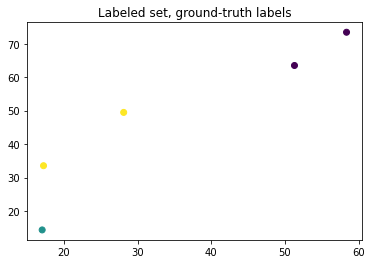

In [122]:
plt.scatter(X_enroll[:, 0], X_enroll[:, 1], c=y_enroll);
#plt.xlim(-10, 15);
#plt.ylim(-12, 8);
plt.title(f'Labeled set, ground-truth labels');

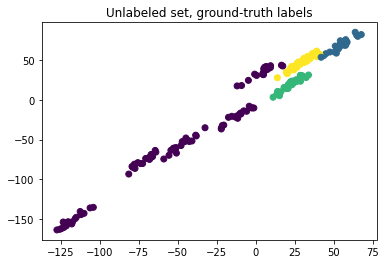

In [123]:
plt.scatter(X[:, 0], X[:, 1], c=y);
#plt.xlim(-10, 15);
#plt.ylim(-12, 8);
plt.title(f'Unlabeled set, ground-truth labels');

# Semi-supervised clustering with the backgroud class
## 1. Variational Bayesian 
## 2. k-means

In [124]:
from torch.distributions.multivariate_normal import MultivariateNormal


def mahalanobis_distance(X, Y, M):
    quad_term1 = torch.sum((X @ M) * X, dim=1, keepdim=True)
    quad_term2 = torch.sum((Y @ M) * Y, dim=1, keepdim=True).t()
    cross_term = 2 * (X @ M) @ Y.t()
    dist = quad_term1 + quad_term2 - cross_term
    return dist

def euclidean_distance(X, Y):
    quad_term1 = torch.sum(X * X, dim=1, keepdim=True)
    quad_term2 = torch.sum(Y * Y, dim=1, keepdim=True).t()
    cross_term = 2 * X @ Y.t()
    dist = quad_term1 + quad_term2 - cross_term
    return dist

In [125]:


def vb_clustering_full(X, labels, X_unlabeled, B, W, threshold):
    
    N, dim = X.shape
    
    dist_outlier = MultivariateNormal(torch.zeros(dim), B + W)
    
    B_inv = torch.linalg.inv(B)
    W_inv = torch.linalg.inv(W)
    B_plus_W_inv = torch.linalg.inv(B + W)
    
    Nu = X_unlabeled.shape[0]
    classes, y = torch.unique(labels, return_inverse=True)
    n_classes = len(classes)
    #print('n_classes', n_classes)
    I = torch.eye(n_classes)
    Y = I[y]
    X_cat = torch.cat([X, X_unlabeled])
    post = torch.zeros(N + Nu, n_classes + 1)
    post[:N, :n_classes] = Y
    post[:N, -1] *= 0

    mu = torch.zeros(n_classes, dim)
    Sigma = torch.zeros(n_classes, dim, dim)

    prior = torch.ones(n_classes + 1)
    p_outlier = torch.sigmoid(threshold)
    prior[-1] = p_outlier
    prior[:n_classes] = (1 - p_outlier) / n_classes
    for _ in range(5):
        # update latent variables
        for k in range(n_classes):
            p = post[:, k].unsqueeze(1)
            Sigma[k] = torch.linalg.inv(B_inv + torch.sum(p) * W_inv)
            m = Sigma[k] @ W_inv @ torch.sum(p * X_cat, dim=0)
            mu[k] = m
        # update assignments
        log_prior = torch.log(prior)
        log_post_outlier = -0.5 * torch.sum((X_cat @ B_plus_W_inv) * X_cat, dim=1, keepdim=True) + 0.5 * torch.logdet(B_plus_W_inv) 
        #log_post_outlier = -0.5 * mahalanobis_distance(X_cat, mu*0, B_plus_W_inv) + 0.5 * torch.logdet(B_plus_W_inv) #
        #log_post_outlier = dist_outlier.log_prob(X_cat).view(-1, 1)
        
        log_post = -0.5 * mahalanobis_distance(X_cat, mu, W_inv) + 0.5 * torch.logdet(W_inv)
#         log_post = torch.zeros(X_cat.shape[0], n_classes)
        for k in range(n_classes):
            log_post[:, k] += -0.5 * torch.trace(W_inv @ Sigma[k])
            
#             dist = MultivariateNormal(mu[k], W)
#             log_post[:, k] += dist_outlier.log_prob(X_cat)
        
        #print(log_post.shape, log_post_outlier.shape)
        log_post = torch.cat([log_post, log_post_outlier], 1)
        #print(log_post.shape)
        log_post += log_prior.view(1, -1)
        post = torch.exp(log_post - torch.logsumexp(log_post, dim=1, keepdim=True))
        # correct assignments for the labeled part
        post[:N, :n_classes] = Y
        post[:N, -1] *= 0

    idx = torch.argmax(post[N:], dim=1)
    mask = idx == n_classes
    idx[mask] = -1
    return idx


def vb_clustering_diag(X, labels, X_unlabeled, w, threshold):
    w = w.view(1, -1)
    w_inv = 1 / w
    b_plus_w_inv = 1 / (1 + w)
    N, dim = X.shape
    Nu = X_unlabeled.shape[0]
    classes, y = torch.unique(labels, return_inverse=True)
    n_classes = len(classes)
    #print('n_classes', n_classes)
    I = torch.eye(n_classes)
    Y = I[y]
    X_cat = torch.cat([X, X_unlabeled])
    post = torch.zeros(N + Nu, n_classes + 1)
    post[:N, :n_classes] = Y
    post[:N, -1] *= 0

    mu = torch.zeros(n_classes, dim)
    Sigma = torch.zeros(n_classes, dim)

    prior = torch.ones(n_classes + 1)
    p_outlier = torch.sigmoid(threshold)
    prior[-1] = p_outlier
    prior[:n_classes] = (1 - p_outlier) / n_classes
    for _ in range(5):
        
        # update latent variables
        n = torch.sum(post[:, :n_classes], dim=0, keepdim=True)
        Sigma = 1 / (1 + torch.mm(n.t(), w_inv))
        mu = Sigma * w_inv.view(1, -1) * torch.mm(post[:, :n_classes].t(), X_cat)

        # update assignments
        log_prior = torch.log(prior)
        #print(log_prior.shape)
        log_post_outlier = -0.5 * torch.sum(X_cat**2 * b_plus_w_inv.view(1, -1), dim=1, keepdim=True) + 0.5 * torch.sum(torch.log(b_plus_w_inv)) 
        log_post = -0.5 * mahalanobis_distance(X_cat, mu, torch.diag(w_inv.view(-1))) + 0.5 * torch.sum(torch.log(w_inv))
        log_post += -0.5 * torch.sum(Sigma * w_inv.view(1, -1), dim=1)
        #print(log_post.shape, log_post_outlier.shape)
        log_post = torch.cat([log_post, log_post_outlier], 1)
        #print(log_post.shape)
        log_post += log_prior.view(1, -1)
        post = torch.exp(log_post - torch.logsumexp(log_post, dim=1, keepdim=True))
        # correct assignments for the labeled part
        post[:N, :n_classes] = Y
        post[:N, -1] *= 0

    idx = torch.argmax(post[N:], dim=1)
    mask = idx == n_classes
    idx[mask] = -1
    return idx


def vb_clustering_sph(X, labels, X_unlabeled, b, w, threshold):
    b_inv = 1/b
    w_inv = 1/w
    b_plus_w_inv = 1/(b + w)
    N, dim = X.shape
    Nu = X_unlabeled.shape[0]
    classes, y = torch.unique(labels, return_inverse=True)
    n_classes = len(classes)
    #print('n_classes', n_classes)
    I = torch.eye(n_classes)
    Y = I[y]
    X_cat = torch.cat([X, X_unlabeled])
    post = torch.zeros(N + Nu, n_classes + 1)
    post[:N, :n_classes] = Y
    post[:N, -1] *= 0

    mu = torch.zeros(n_classes, dim)
    Sigma = torch.zeros(n_classes)

    prior = torch.ones(n_classes + 1)
    p_outlier = torch.sigmoid(threshold)
    prior[-1] = p_outlier
    prior[:n_classes] = (1 - p_outlier) / n_classes
    for _ in range(5):
        
        # update latent variables
        n = torch.sum(post[:, :n_classes], dim=0)
        Sigma = 1 / (b_inv + n * w_inv)
        mu = w_inv * Sigma.view(-1, 1) * torch.mm(post[:, :n_classes].t(), X_cat)

        # update assignments
        log_prior = torch.log(prior)
        # print(log_prior.shape)
        log_post_outlier = -0.5 * b_plus_w_inv * torch.sum(X_cat ** 2, dim=1, keepdim=True) + 0.5 * dim * torch.log(b_plus_w_inv) # outlier
        #w_inv_sqrt = w_inv ** 0.5
        log_post = -0.5 * w_inv * euclidean_distance(X_cat, mu) + 0.5 * dim * torch.log(w_inv)
        log_post += -0.5 * dim * w_inv * Sigma
        # print(log_post.shape, log_post_outlier.shape)
        log_post = torch.cat([log_post, log_post_outlier], 1)
        # print(log_post.shape)
        log_post += log_prior.view(1, -1)
        post = torch.exp(log_post - torch.logsumexp(log_post, dim=1, keepdim=True))
        # correct assignments for the labeled part
        post[:N, :n_classes] = Y
        post[:N, -1] *= 0

    idx = torch.argmax(post[N:], dim=1)
    mask = idx == n_classes
    idx[mask] = -1
    return idx


def kmeans_clustering(X, labels, X_unlabeled, similarity_score, threshold):
    N, dim = X.shape
    Nu = X_unlabeled.shape[0]
    classes, y = torch.unique(labels, return_inverse=True)
    n_classes = len(classes)
    I = torch.eye(n_classes)
    Y = I[y]
    means = Y.t() @ X
    X_all = torch.cat([X, X_unlabeled])
    # k-means with known classes and outliers
    for iteration in range(10):
        scores = torch.cat([similarity_score(x.view(1, -1), means).view(1, -1) for x in X_all])  #TODO: faster implementation
        scores_max, y_pred_all = torch.max(scores, dim=1)
        y_pred_all[:N] = y
        mask_known = scores_max > threshold
        mask_known[:N] = 1
        Y = I[y_pred_all[mask_known]]
        means = Y.t() @ X_all[mask_known]
    counts_all = Y.sum(0)
    return means, counts_all

In [132]:
T = lambda x: torch.tensor(x).float()

In [170]:
#B = np.mean(np.var(X, axis=0)) # B
W = Sigma_wc 
B = np.cov(X, rowvar=False)
#B = 10 * W

In [171]:
# for k in range(3):
#     print(np.mean(np.var(X[y==k], axis=0))) # W

[0.01364661 0.04373888]
[[ 1.00000000e+00 -8.88178420e-16]
 [-8.60422844e-16  1.00000000e+00]]
[[ 1.36466092e-02 -1.38777878e-17]
 [-1.32272665e-17  4.37388816e-02]]


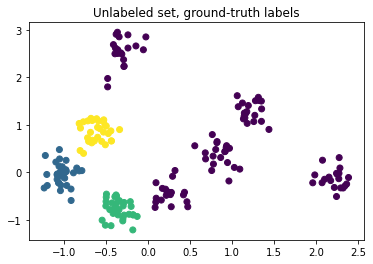

In [172]:
from scipy.linalg import eigh

w_vec, Tr = eigh(W, B)

print(w_vec)
print(Tr.T @ B @ Tr) # = eye
print(Tr.T @ W @ Tr) # = diag

B_tr = Tr.T @ B @ Tr
W_tr = Tr.T @ W @ Tr

X_tr = X @ Tr

plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y);
#plt.xlim(-10, 15);
#plt.ylim(-12, 8);
plt.title(f'Unlabeled set, ground-truth labels');

In [173]:
W, W_tr

(array([[40.41, 49.23],
        [49.23, 65.7 ]]),
 array([[ 1.36466092e-02, -1.38777878e-17],
        [-1.32272665e-17,  4.37388816e-02]]))

In [204]:
#W_tr = W_tr * np.eye(dim)

array([[ 0.01364661, -0.        ],
       [-0.        ,  0.04373888]])

In [206]:
dist = MultivariateNormal(torch.zeros(dim), T(W))
dist_new = MultivariateNormal(torch.zeros(dim), T(W_tr))

dist.log_prob(T(X)).sum(), dist_new.log_prob(T(X_tr)).sum(), 0.5 * (torch.logdet(T(W)) - torch.logdet(T(W_tr))) * len(X)

(tensor(-10609.3496), tensor(-9354.7471), tensor(1254.5996))

In [207]:
torch.logdet(T(W)), torch.logdet(T(W_tr)), torch.logdet(T(W)) - torch.logdet(T(W_tr)), torch.logdet(T(Tr @ Tr.T))

(tensor(5.4439), tensor(-7.4238), tensor(12.8677), tensor(-12.8677))

In [208]:
(dist.log_prob(T(X)).sum() - dist_new.log_prob(T(X_tr)).sum())

tensor(-1254.6025)

In [212]:
 torch.logdet(T(Tr @ Tr.T)) * 0.5

tensor(-6.4338)

In [211]:
dist.log_prob(T(X))[:5] - dist_new.log_prob(T(X_tr))[:5]

tensor([-6.4338, -6.4338, -6.4339, -6.4338, -6.4338])

In [214]:
a = torch.tensor([[-93.6057],
        [-93.8288],
        [-94.1419],
        [-93.9702],
        [-93.2268],
        [-94.3472],
        [-94.8933],
        [-93.7700],
        [-93.6625],
        [-94.4355],
        [-94.7245],
        [-94.1449],
        [-94.1795],
        [-93.6951],
        [-94.3532],
        [-94.0258],
        [-93.8919],
        [-94.1483],
        [-93.1562],
        [-93.8719]])

b = torch.tensor([[-55.1830],
        [-55.4061],
        [-55.7191],
        [-55.5474],
        [-54.8040],
        [-55.9244],
        [-56.4705],
        [-55.3472],
        [-55.2397],
        [-56.0127],
        [-56.3017],
        [-55.7221],
        [-55.7567],
        [-55.2723],
        [-55.9304],
        [-55.6031],
        [-55.4691],
        [-55.7255],
        [-54.7334],
        [-55.4492]])

a - b

tensor([[-38.4227],
        [-38.4227],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4227],
        [-38.4228],
        [-38.4228],
        [-38.4228],
        [-38.4227]])

In [80]:
# b = 12
# w = 0.25
# B = torch.eye(2) * b
# W = torch.eye(2) * w
# w_vec = torch.ones(2) * w/b

# Tr = np.eye(2) / np.sqrt(b)


0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00
0.00 0.00


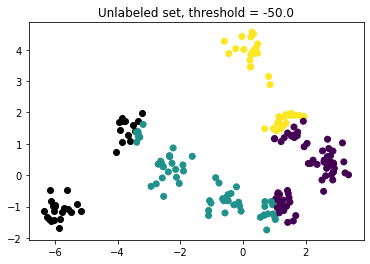

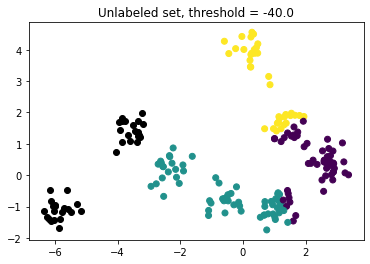

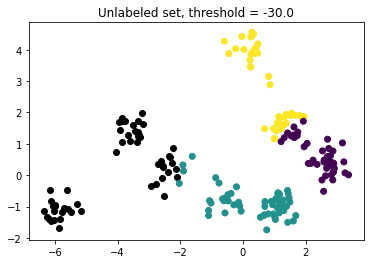

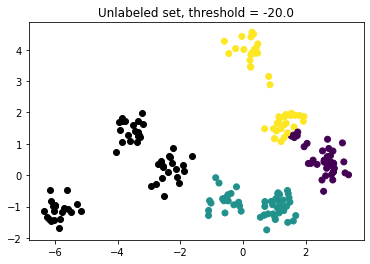

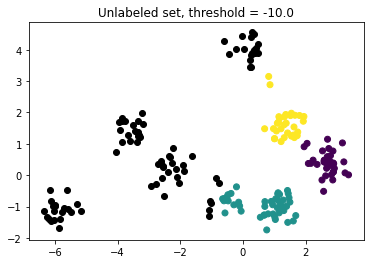

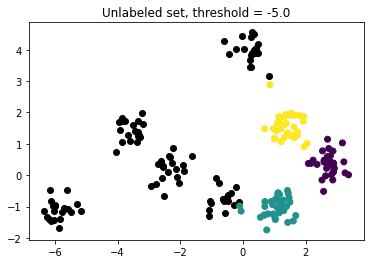

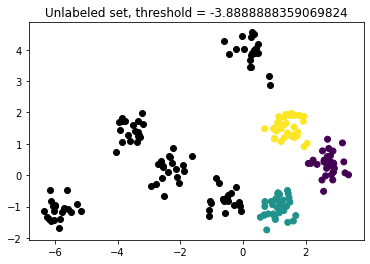

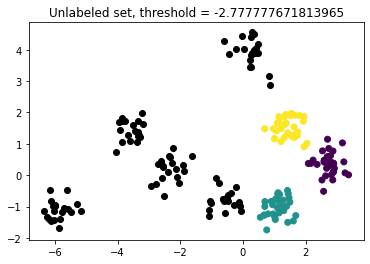

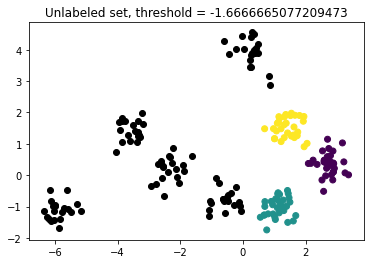

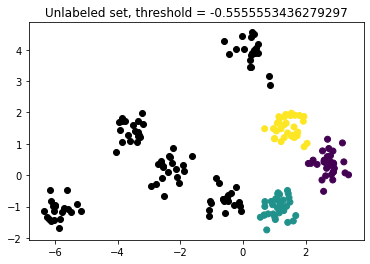

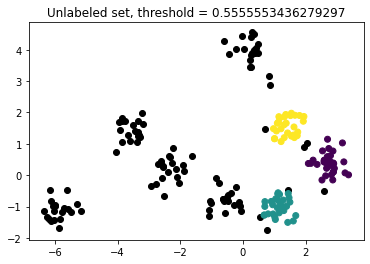

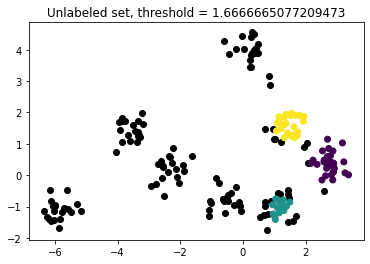

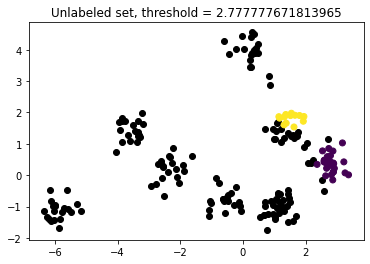

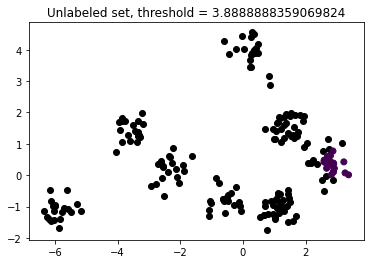

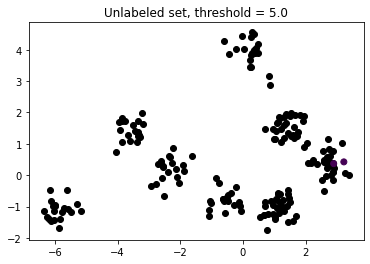

In [81]:
for threshold in torch.cat([torch.linspace(-50, -10, 5), torch.linspace(-5, 5, 10)]):

    y_pred_full = vb_clustering_full(T(X_enroll), T(y_enroll), T(X), T(B), T(W), threshold).numpy()
    y_pred_diag = vb_clustering_diag(T(np.matmul(X_enroll, Tr)), T(y_enroll), T(np.matmul(X, Tr)), T(w_vec), threshold).numpy()
    b = 1
    w = np.mean(w_vec) # approximation
    y_pred_sph = vb_clustering_sph(T(np.matmul(X_enroll, Tr)), T(y_enroll), T(np.matmul(X, Tr)), T(b), T(w), threshold).numpy()
    
    
    diff = np.mean(y_pred_full != y_pred_sph)
    diff2 = np.mean(y_pred_full != y_pred_diag)
    print(f"{diff:.2f} {diff2:.2f}")
    
    
    y_pred = y_pred_full

    plt.figure()
    plt.scatter(X_tr[y_pred==-1, 0], X_tr[y_pred==-1, 1], c='k');
    plt.scatter(X_tr[y_pred!=-1, 0], X_tr[y_pred!=-1, 1], c=y_pred[y_pred!=-1]);
    plt.title(f'Unlabeled set, threshold = {threshold}');

In [383]:
import numpy as np
from scipy.special import gammaln, psi
from numpy.random import choice
from scipy.special import expit as sigmoid
from scipy.special import logit
from scipy.optimize import minimize, minimize_scalar

#from lib.special.softplus import softplus, softplusinv
#from lib.combin.partitions import partitions_and_subsets


class CRP:
    def __init__(self, alpha, beta):
        assert alpha >= 0 <= beta <= 1
        self.alpha = alpha
        self.beta = beta
        
    def sample(self,n):
        alpha, beta = self.alpha, self.beta
        labels = np.zeros(n,int)  # restricted growth string, labels start at 0   
        counts = np.zeros(n,int)  # table occupancies (up to n tables)
        p = np.empty(n)
        counts[0] = 1             # seat first customer at table 0
        nt = 1                    # number of occupied tables  
        for i in range(1,n):      # seat rest of customers
            # i is number of seated customers and index of to-be-seated customer
            pi = p[:nt+1]
            pi[:nt] = (counts[:nt] - beta) / (i + alpha) # occupied tables
            pi[nt] = (alpha + nt*beta ) / (i + alpha)    # new table
            t = choice(nt+1, None, True, pi)             # chosen table
            labels[i] = t
            counts[t] += 1
            if t == nt: nt += 1                          # new table was chosen
        return labels, counts[:nt]    
    
    def samples(self,n,m):
        """
        Sample m independent partitions of size n from this CRP
        Returns a list of m arrays of block sizes.
        (The array sizes are variable, depending on the number of blocks in 
        the partition.)
        """
        assert n >= 1 <= m
        counts_list = []
        for i in range(m):
            labels, counts = self.sample(n)
            counts_list.append(counts)
        return counts_list
    
    # def logprob(self,counts):
    #     """
    #     Returns log P(labels | crp), where labels is represented by the given
    #     table occupancy counts.
    #     """
    #     alpha, beta = self.alpha, self.beta
    #
    #     if alpha == np.Inf and beta==1: #singleton tables
    #         return 0.0 if all(counts==1) else -np.Inf
    #
    #     if alpha==0 and beta==0:       #single table
    #         return 0.0 if len(counts)==1 else -np.Inf
    #
    #     if alpha>0 and beta>0:  # general case (2 parameter Pitman-Yor CRP)
    #         return logprob_alpha_beta(alpha,beta,counts)
    #
    #     if beta==0 and alpha>0:  # classical 1-parameter CRP
    #        return logprob_alpha(alpha,counts)
    #
    #     if beta>0 and alpha==0:
    #         return logprob_beta(beta,counts)
    #
    #     assert False
        
    def llr_joins(self,counts,i):
        """
        Let logLR(i,j) = log P(join(i,j)|crp) - log P( labels| crp), where
        labels is represented by the given occupancy counts; and where join(i,j)
        joins tables i and j, while leaving other tables as-is. A vector is 
        returned with all logLR(i,j), with j > i. 
        
        For use by AHC (agglomerative hierarchical clustering) algorithms that 
        seek greedy MAP partitions, where this CRP forms the partition prior.
        """
        alpha, beta = self.alpha, self.beta
        K = len(counts)  # tables
        assert K > 1
        ci = counts[i]
        cj = counts[i+1:]
        llr = gammaln(1-beta) - np.log(beta) - np.log(alpha/beta + K-1) 
        llr += gammaln(cj+(ci-beta)) - gammaln(ci-beta) - gammaln(cj-beta) 
        return llr

    def exp_num_tables(self,n):
        """
        n: number of customers
        """
        alpha, beta = self.alpha, self.beta
        if alpha==0 and beta==0:
            e = 1
        elif alpha == np.Inf:
            e = n
        elif alpha>0 and beta>0:      
            A = gammaln(alpha + beta + n) + gammaln(alpha + 1) \
                - np.log(beta) - gammaln(alpha+n) - gammaln(alpha+beta)
            B = alpha/beta
            e = B*np.expm1(A-np.log(B))   # exp(A)-B
        elif alpha>0 and beta==0:
            e = alpha*( psi(n+alpha) - psi(alpha) )
        elif alpha==0 and beta>0:
            A = gammaln(beta + n) - np.log(beta) - gammaln(n) - gammaln(beta)
            e = np.exp(A)
        return e
    
    def __repr__(self):
        return f"CRP(alpha={self.alpha}, beta={self.beta})"

#     def logprobtable(self,P,S=None):
#         """
#         Returns pre-computed table of log-probabilities, for every partition
#         of a set of n elements. 
        
#         Usage:
            
#             P, S = lib.combin.partitions_and_subsets(n,dtype=bool)
#             table = crp.logprobtable(P,S)
        
#         or, equivalently:
            
#             table = crp.logprobtable(n)
        
#         """
#         if S is None: 
#             assert type(P)==int and P>0
#             P,S = partitions_and_subsets(P,dtype=bool)
#         counts = S.sum(axis=1)
#         Bn, ns = P.shape
#         L = [self.logprob(counts[P[i,:].astype(bool,copy=False)]) for i in range(Bn)]
#         return np.array(L)

    def ahc(self,labels):
        """
        Returns an AHC object, initialized at the given labels.
        
        For use by AHC (agglomerative hierarchical clustering) algorithms that 
        seek greedy MAP partitions, where this CRP forms the partition prior.
        
        """
        return AHC(self,labels)

    
class AHC:
    """
        For use by AHC (agglomerative hierarchical clustering) algorithms that 
        seek greedy MAP partitions, where this CRP forms the partition prior.
    """    
    def __init__(self,crp,labels):
        self.crp = crp
        tables, counts = np.unique(labels,return_counts=True)
        self.counts = counts
        
    def llr_joins(self,i):
        """
        Scores in logLR form, the CRP prior's contribution when joining tables
        i with all tables j > i.
        """
        crp, counts = self.crp, self.counts
        return crp.llr_joins(counts,i)
    
    def join(self,i,j):
        """
        Joins tables i and j in this AHC object.
        """
        counts = self.counts
        counts[i] += counts[j]
        self.counts = np.delete(counts,j)
        

class SingletonDict(dict):
    def __getitem__(self,key):
        return super().__getitem__(key) if key in self else {key}


class ClusteringAHC:
    def __init__(self, w_inv, alpha, beta, X, B=None):
        if B is not None:
            assert X.shape == B.shape
        n,d = X.shape
        
        prior = CRP(alpha, beta)
        
        self.n = self.N = n
        if B is None:
            self.R = R = np.tile(w_inv,(n,1))
        else:
            self.R = R = (w_inv * B) / (w_inv + B)
        self.RX = RX = R*X         #(n,d)
        
        self.LLH = (RX**2/(1.0 + R) - np.log1p(R) ).sum(axis=1) / 2.0  #(n,)
        self.LLRs = []
        
        labels = np.arange(n, dtype=int) # full length labels, contains result
        self.ind = labels.copy() # 
        
        self.prior_ahc = prior.ahc(labels)
        
        # map every element to a singleton cluster containing that element
        self.clusters = SingletonDict()     
        
    def join(self,i,j):
        clusters = self.clusters
        join = clusters[i] | clusters[j]
        for e in join: clusters[e] = join
        
        
    def iteration(self, thr = 0.0):
        RX, R, n = self.RX, self.R, self.n
        prior_ahc, LLH = self.prior_ahc, self.LLH
        ind = self.ind
        
        #M = np.full((n,n),-np.Inf)
        
        maxval = -np.Inf
        for i in range(n-1):
            r = R[i,:]                    # (d,)      
            rR = r + R[i+1:,:]            # (n-i-1, d)
            rx = RX[i,:]
            rxRX = rx + RX[i+1:,:]
            llh = (rxRX**2/(1.0+rR) - np.log1p(rR) ).sum(axis=1) / 2.0  
            score = llh + prior_ahc.llr_joins(i) - LLH[i] - LLH[i+1:]
            #M[i,i+1:] = score
            j = score.argmax()
            scj = score[j]
            #print(i,i+j+1,': ',np.around(np.exp(scj),1))
            if scj > maxval:
                maxi = i
                maxj = j + i + 1
                maxval = scj
        
        #print(np.around(np.exp(M),1),'\n')
        LLRs = self.LLRs
        LLRs.append(maxval)         
          
        if maxval > thr:
            
            #print('joining: ',maxi,'+',maxj)
            #print('ind = ',ind)
            ii, jj = ind[maxi], ind[maxj]
            #print('joining: ',ii,'+',jj)
            self.join(ii,jj)
            
            
            RX[maxi,:] += RX[maxj,:]
            R[maxi,:] += R[maxj,:]        
            self.RX = np.delete(RX,maxj,axis=0)         
            self.R = np.delete(R,maxj,axis=0)

            self.n = n-1

            prior_ahc.join(maxi,maxj) 

            LLH[maxi] = maxval + LLH[maxi] + LLH[maxj]
            self.LLH = np.delete(LLH,maxj)

            self.ind = np.delete(ind,maxj)
        
        return maxval
    
    
    def cluster(self, thr = 0.0):
        while self.n > 1:
            llr = self.iteration(thr)
            if llr <= thr: break
        #return clusters2labels(self.clusters,self.N)
        return self.labelclusters()
    
    
    def labelclusters(self):
        clusters, n = self.clusters, self.N
        labels = np.full(n,-1)
        label = -1
        for i in range(n):
            s = clusters[i]
            for e in s: break #get first set element
            if labels[e] < 0: 
                label += 1
                labels[list(s)] = label
        return labels


class SSClusteringAHC:
    def __init__(self, w_inv, alpha, beta, X, X_labeled, y):
        B = None
        n, d = X.shape
        N = X_labeled.shape[0]
        
        self.y = y

        prior = CRP(alpha, beta)

        self.n = self.N = n+N
        Xx = np.r_[X_labeled, X]

        if B is None:
            self.R = R = np.tile(w_inv, (self.n, 1))
        else:
            self.R = R = (w_inv * B) / (w_inv + B)
        self.RX = RX = R * Xx  # (n,d)

        self.LLH = (RX ** 2 / (1.0 + R) - np.log1p(R)).sum(axis=1) / 2.0  # (n,)
        self.LLRs = []

        #labels = np.r_[y, 1 + np.max(y) + np.arange(n, dtype=int)]  # full length labels, contains result
        labels = np.arange(self.n, dtype=int)
        self.ind = labels.copy()  #
        #print(labels)
        
        #print(n, N, self.n, self.LLH.shape, labels.shape, self.R.shape, self.RX.shape)

        self.prior_ahc = prior.ahc(labels)

        # map every element to a singleton cluster containing that element
        self.clusters = SingletonDict()
        
        # join labeled data into clusters
        # maxj > maxi
        y_labeled = np.r_[y, 1 + np.max(y) + np.arange(n, dtype=int)]
        
        while np.max(np.unique(y_labeled, return_counts=True)[1]) > 1:
            classes, counts = np.unique(y_labeled, return_counts=True)
            for idx, count in enumerate(counts):
                if count > 1:
                    
                    c = classes[idx]
                    mask = y_labeled == c
                    idxs = np.arange(len(y_labeled))[mask]
                    maxi = idxs[0]
                    maxj = idxs[1]
                    #print(maxi, maxj)
                    #print('clusters:', self.clusters)
                    

                    # join
                    RX, R, n = self.RX, self.R, self.n
                    prior_ahc, LLH = self.prior_ahc, self.LLH
                    ind = self.ind

                    i = maxi
                    j = maxj - (i + 1) 

                    r = R[i,:]                    # (d,)      
                    rR = r + R[i+1:,:]            # (n-i-1, d)
                    rx = RX[i,:]
                    rxRX = rx + RX[i+1:,:]
                    llh = (rxRX**2/(1.0+rR) - np.log1p(rR) ).sum(axis=1) / 2.0  
                    maxvals = llh + prior_ahc.llr_joins(i) - LLH[i] - LLH[i+1:]
                    maxval = maxvals[j]
                    
                    ii, jj = ind[maxi], ind[maxj]

                    self.join(ii, jj)

                    RX[maxi, :] += RX[maxj, :]
                    R[maxi, :] += R[maxj, :]
                    self.RX = np.delete(RX, maxj, axis=0)
                    self.R = np.delete(R, maxj, axis=0)

                    self.n = n - 1

                    prior_ahc.join(maxi, maxj)

                    LLH[maxi] = maxval + LLH[maxi] + LLH[maxj]
                    self.LLH = np.delete(LLH, maxj)
                    self.ind = np.delete(ind, maxj)
                    
                    #
                    y_labeled = np.delete(y_labeled, maxj)
                    
                    break
                    
                    #print(self.RX.shape, self.R.shape, self.LLH.shape, self.ind.shape)


        #print('clusters:', self.clusters)
        
        from collections import defaultdict
        self.cannot_link = defaultdict(list)
        idxs = np.arange(len(y), dtype=int)
        for c in np.unique(y):
            mask = y == c
            class_idxs = idxs[mask]
            rest_idxs = idxs[np.logical_not(mask)]
            for i in class_idxs:
                for j in rest_idxs:
                    self.cannot_link[i].append(j)
        #print(self.cannot_link)


    def can_join(self, i, j):
        clusters = self.clusters
        #join = clusters[i] | clusters[j]
        allow = True
        for a in clusters[i]:
            for b in clusters[j]:
                if b in self.cannot_link[a] or a in self.cannot_link[b]: #TODO: check
                    allow = False
        return allow

    def join(self, i, j):
        clusters = self.clusters
        join = clusters[i] | clusters[j]
        for e in join: clusters[e] = join

    def iteration(self, thr=0.0):
        RX, R, n = self.RX, self.R, self.n
        prior_ahc, LLH = self.prior_ahc, self.LLH
        ind = self.ind

        # M = np.full((n,n),-np.Inf)

        scores_list = [-np.inf] # scores for the upper triangle of the full score matrix
        pairs = [(0, 0)]
        for i in range(n - 1):
            r = R[i, :]  # (d,)
            rR = r + R[i + 1:, :]  # (n-i-1, d)
            rx = RX[i, :]
            rxRX = rx + RX[i + 1:, :]
            llh = (rxRX ** 2 / (1.0 + rR) - np.log1p(rR)).sum(axis=1) / 2.0
            scores = llh + prior_ahc.llr_joins(i) - LLH[i] - LLH[i + 1:]
            scores_list += scores.tolist()
            pairs += [(i, j) for j in range(i + 1, n)]

        #print(len(scores_list), scores_list[:5])
        scores = np.array(scores_list)
        pairs = np.array(pairs)
        idx_sort = np.argsort(scores)[::-1] # largest first
        scores = scores[idx_sort]
        pairs = pairs[idx_sort]

        for maxval, (maxi, maxj) in zip(scores, pairs):
            ii, jj = ind[maxi], ind[maxj]
            if self.can_join(ii, jj):
                
                LLRs = self.LLRs
                LLRs.append(maxval)
                
                if maxval > thr:
                    
                    self.join(ii, jj)
                    print("Join:", ii, jj)

                    RX[maxi, :] += RX[maxj, :]
                    R[maxi, :] += R[maxj, :]
                    self.RX = np.delete(RX, maxj, axis=0)
                    self.R = np.delete(R, maxj, axis=0)

                    self.n = n - 1

                    prior_ahc.join(maxi, maxj)

                    LLH[maxi] = maxval + LLH[maxi] + LLH[maxj]
                    self.LLH = np.delete(LLH, maxj)
                    self.ind = np.delete(ind, maxj)
                break
            else:
                pass
                print("Cannot join:", ii, jj)
                #continue
        return maxval

    def cluster(self, thr=0.0):
        while self.n > 1:
            llr = self.iteration(thr)
            if llr <= thr: break
            #print(self.clusters[1])
        # return clusters2labels(self.clusters,self.N)
        return self.labelclusters()

    def labelclusters(self):
        clusters, n = self.clusters, self.N
        labels = np.full(n, -1)
        #label = -1
        label = max(self.y)
        for i in range(n):
            s = clusters[i]
            #for e in s: break  # get first set element
            e = min(s)
            if labels[e] < max(self.y) + 1:
                #labels[list(s)] = label
                if e < len(self.y):
                    labels[list(s)] = self.y[e]
                    #print(list(s), "<-------", self.y[e])
                else:
                    label += 1
                    labels[list(s)] = label
        return labels[len(self.y):]


In [403]:
X_toy = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])

X_toy_enr = np.array([[0.2, 0], [1.2, 1.]])
y_toy_enr = np.array([0, 1])


clusterer = SSClusteringAHC(w_inv*0.1, alpha, beta, X_toy, X_toy_enr, y_toy_enr)

y_pred_all = clusterer.cluster(0.0)

Join: 1 4
Join: 1 5
Join: 0 2
Join: 0 3
Cannot join: 0 1


In [404]:
y_pred_all

array([0, 1, 0, 0, 1, 1])

In [405]:
np.r_[X_toy_enr, X_toy]

array([[0.2, 0. ],
       [1.2, 1. ],
       [0. , 0. ],
       [0. , 1. ],
       [1. , 1. ],
       [1. , 0. ]])

In [344]:
#B = np.mean(np.var(X, axis=0)) # B
W = Sigma_wc 
B = np.cov(X, rowvar=False)
#B = 10 * W

[0.01364661 0.04373888]
[[ 1.00000000e+00 -8.88178420e-16]
 [-8.60422844e-16  1.00000000e+00]]
[[ 1.36466092e-02 -1.38777878e-17]
 [-1.32272665e-17  4.37388816e-02]]


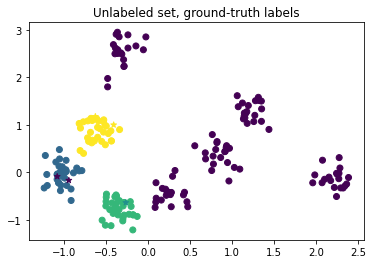

In [360]:
from scipy.linalg import eigh

w_vec, Tr = eigh(W, B)

print(w_vec)
print(Tr.T @ B @ Tr) # = eye
print(Tr.T @ W @ Tr) # = diag

X_tr = X @ Tr
X_enroll_tr = X_enroll @ Tr



plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y);
plt.scatter(X_enroll_tr[:, 0], X_enroll_tr[:, 1], c=y_enroll[:], marker="*");
plt.title(f'Unlabeled set, ground-truth labels');

In [361]:
#from clustering_ahc_plda import ClusteringAHC, SSClusteringAHC

In [347]:
X.shape, X_enroll.shape

((195, 2), (5, 2))

In [348]:
y_enroll

array([0, 2, 2, 1, 0])

In [349]:
np.sum(y_pred==0)

31

Predicted number of clusters: 10


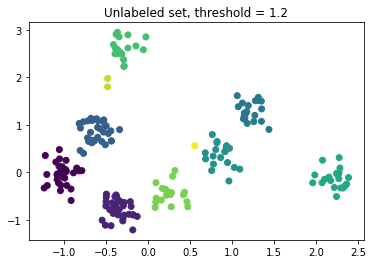

In [378]:
alpha = 1.
beta = 0.1

w_inv = 1 / w_vec


for threshold in [1.2]:
    
    y_enroll_ = y_enroll.copy()
    y_enroll_[2] = 3
    
    clusterer = SSClusteringAHC(w_inv, alpha, beta, X_tr, X_enroll_tr, y_enroll_)
    #clusterer = ClusteringAHC(w_inv, alpha, beta, X_tr)
    
    #print("Clustering")

    y_pred_all = clusterer.cluster(threshold)
    #print(y_pred.shape, X.shape)
    
    y_pred = y_pred_all[len(y_enroll):]
    
    print("Predicted number of clusters:", len(np.unique(y_pred)))
        

    plt.figure()
    plt.scatter(X_tr[y_pred==-1, 0], X_tr[y_pred==-1, 1], c='k');
    plt.scatter(X_tr[y_pred!=-1, 0], X_tr[y_pred!=-1, 1], c=y_pred[y_pred!=-1]);
    plt.title(f'Unlabeled set, threshold = {threshold}');

In [363]:
y_enroll

array([0, 2, 2, 1, 0])

In [364]:
y_pred_all

array([0, 2, 3, 1, 0, 1, 0, 1, 3, 0, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 0, 3,
       1, 0, 1, 0, 3, 0, 0, 0, 3, 3, 3, 1, 0, 1, 0, 1, 1, 1, 1, 3, 1, 3,
       1, 0, 3, 1, 1, 0, 1, 0, 3, 1, 0, 1, 1, 1, 3, 3, 3, 0, 3, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 0, 0, 1, 1, 0,
       1, 3, 1, 0, 1, 1, 3, 0, 0, 3, 0, 0, 4, 5, 4, 6, 7, 7, 7, 5, 7, 6,
       4, 4, 8, 8, 6, 5, 6, 7, 7, 8, 4, 6, 6, 8, 8, 6, 4, 8, 6, 4, 8, 4,
       7, 5, 6, 7, 8, 5, 8, 7, 6, 5, 5, 6, 7, 4, 7, 5, 4, 6, 8, 6, 6, 6,
       6, 8, 4, 6, 8, 5, 8, 4, 5, 5, 7, 8, 6, 4, 5, 5, 7, 4, 7, 6, 4, 5,
       7, 5, 7, 5, 7, 4, 8, 7, 4, 8, 4, 5, 7, 4, 8, 4, 6, 8, 8, 5, 9, 8,
       5, 7])

In [365]:
y_pred[0]

1

In [366]:
y_pred[28]

1

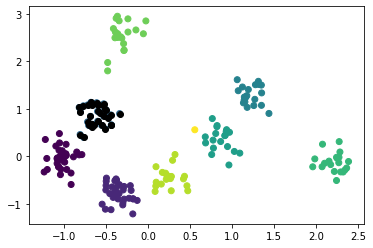

In [369]:
plt.scatter(X_tr[y_pred!=-1, 0], X_tr[y_pred!=-1, 1], c=y_pred[y_pred!=-1]);
plt.scatter(X_tr[y_pred==3, 0], X_tr[y_pred==3, 1], c='k');
plt.scatter(X_tr[y_pred==2, 0], X_tr[y_pred==2, 1], c='c');

IndexError: index 6 is out of bounds for axis 0 with size 5

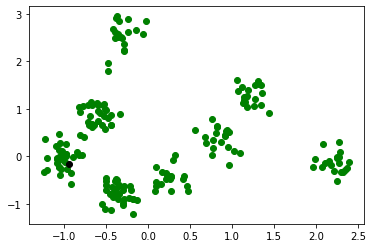

In [259]:
plt.scatter(X_tr[:, 0], X_tr[:, 1], c='g');
plt.scatter(X_enroll_tr[0, 0], X_enroll_tr[0, 1], c='k');
plt.scatter(X_enroll_tr[1, 0], X_enroll_tr[1, 1], c='k');

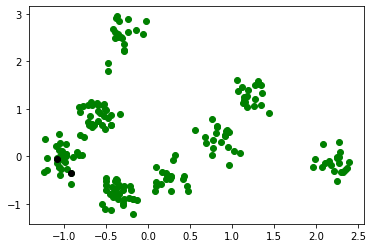

In [260]:
plt.scatter(X_tr[:, 0], X_tr[:, 1], c='g');
plt.scatter(X_tr[1, 0], X_tr[1, 1], c='k');
plt.scatter(X_tr[4, 0], X_tr[4, 1], c='k');

In [384]:
y_pred_all

array([0, 1, 1, 1, 1, 1])

In [89]:
scale = 0.06603098215498167
shift = -1.7273728530999115

scale * 150 + shift, scale * 200 + shift, scale * 259 + shift

(8.177274470147339, 11.478823577896422, 15.374651525040342)